In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr

from scipy import stats
from scipy.special import expit
from matplotlib.colors import Normalize, to_hex

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set seed
seed = 8888
rng = np.random.default_rng(seed)

# Get point colours from colourmap
norm = Normalize(vmin=-0.5, vmax=1.5)
cmap1 = plt.get_cmap('Greys')
cmap2 = plt.get_cmap('Reds')

# Map each scalar to a color
blacks = [to_hex(cmap1(norm(value))) for value in [0,1]]
reds = [to_hex(cmap2(norm(value))) for value in [0,1]]

# The fork
### X &larr; Z &rarr; Y
#### For discrete variables

In [3]:
Z = rng.binomial(1, 0.5, size=1000)
X = rng.binomial(1, (1-Z)*0.1 + Z*0.9, size=1000)
Y = rng.binomial(1, (1-Z)*0.1 + Z*0.9, size=1000)

Here, both `X` and `Y` are correlated to each other because they have a common cause `Z`. We will output the correlation coefficient of `X` and `Y` to see this. We will then once again output the correlation coefficient of `X` and `Y`, but this time stratified by `Z` and see that `X` and `Y` are independent of each other once this common cause is removed.

In [4]:
xy_corr = np.corrcoef(X,Y)

xy_corr_z0 = np.corrcoef(X[Z==0],Y[Z==0])
xy_corr_z1 = np.corrcoef(X[Z==1],Y[Z==1])

print(xy_corr[0,1], xy_corr_z0[0,1], xy_corr_z1[0,1])

0.6618924564862559 0.10551116861213865 0.02683722185656037


#### For continuous variables

In [5]:
Z = rng.binomial(1, 0.5, size=500)
X = rng.normal(2*(Z-1), size=500)
Y = rng.normal(2*(Z-1), size=500)

lm_xy = stats.linregress(X, Y)
lm_xy_z0 = stats.linregress(X[Z==0], Y[Z==0])
lm_xy_z1 = stats.linregress(X[Z==1], Y[Z==1])

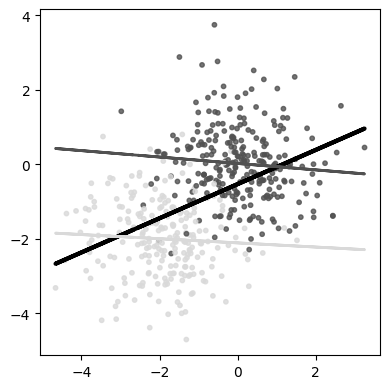

In [6]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(X, Y, c=Z, cmap='Greys', s=10, alpha=0.8, vmin=-0.5, vmax=1.5)
ax.plot(X, lm_xy[1] + lm_xy[0] * X, c='black', linewidth=3)
ax.plot(X, lm_xy_z0[1] + lm_xy_z0[0] * X, c=blacks[0], linewidth=2)
ax.plot(X, lm_xy_z1[1] + lm_xy_z1[0] * X, c=blacks[1], linewidth=2)

plt.tight_layout()
plt.show()

The fork induces an association between two variables because they share a common cause. Once you stratify by that common cause, the variables become unrelated. Now we will see why we care about the fork in an example with real data.

# 1. State a clear question
- Why do regions in the US with higher marriage rates also have higher divorce rates?

### Load data
The dataframe consists of the marriage and divorce rates, the population and the number of waffle houses in various states of the United States.

In [7]:
df = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/pymc/pymc-resources/Rethinking_2/Data/WaffleDivorce.csv', sep=';')
df = df.loc[:,['MedianAgeMarriage', 'Marriage', 'Divorce']]
df.head()

,MedianAgeMarriage,Marriage,Divorce
0,25.3,20.2,12.7
1,25.2,26.0,12.5
2,25.8,20.3,10.8
3,24.3,26.4,13.5
4,26.8,19.1,8.0


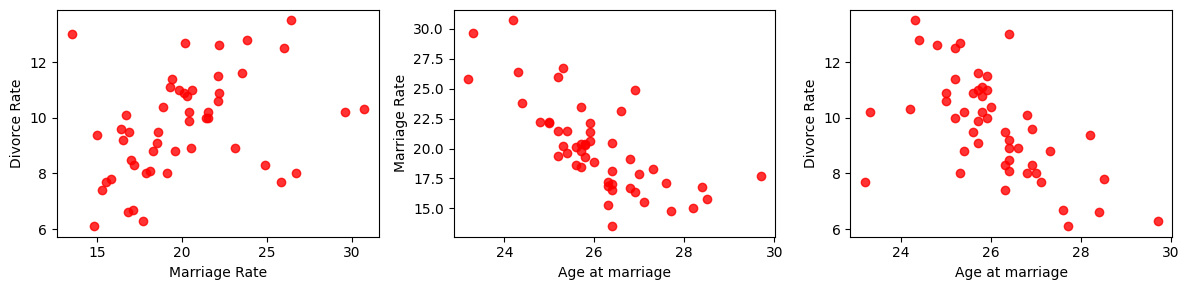

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))

ax1.scatter(df['Marriage'], df['Divorce'], c='red', alpha=0.8)
ax1.set_xlabel('Marriage Rate')
ax1.set_ylabel('Divorce Rate')

ax2.scatter(df['MedianAgeMarriage'], df['Marriage'], c='red', alpha=0.8)
ax2.set_xlabel('Age at marriage')
ax2.set_ylabel('Marriage Rate')

ax3.scatter(df['MedianAgeMarriage'], df['Divorce'], c='red', alpha=0.8)
ax3.set_xlabel('Age at marriage')
ax3.set_ylabel('Divorce Rate')

plt.tight_layout()
plt.show()

# 2. Sketch out the causal assumptions (DAG) of the model
M &rarr; D  
&uarr; ↗  
A

# 3. Define a generative model
### Generate data
Here, we generate synthetic data based on causal assumptions of our system and visualise these data.

In [9]:
def sim_MD(A, a, b):
    N = len(A)
    M = a[0] + b[0] * A + rng.normal(0, 2, size=N)
    D = a[1] + b[1] * A + rng.normal(0, 3, size=N)
    
    sim_data = pd.DataFrame({'age': A, 'marriage': M, 'divorce': D})
    
    return sim_data

Now that we've defined a simulation, we can simulate data to answer our question.

#### Effect of marriage rate on divorce rate

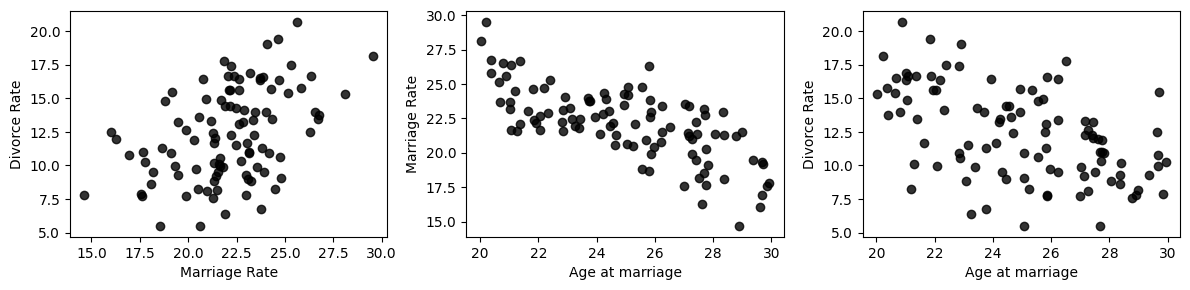

In [10]:
A = np.random.uniform(20, 30, size=100)
a = [40, 30]
b = [-0.7, -0.7]
sim_data = sim_MD(A, a, b)

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))

ax1.scatter(sim_data['marriage'], sim_data['divorce'], c='black', alpha=0.8)
ax1.set_xlabel('Marriage Rate')
ax1.set_ylabel('Divorce Rate')

ax2.scatter(sim_data['age'], sim_data['marriage'], c='black', alpha=0.8)
ax2.set_xlabel('Age at marriage')
ax2.set_ylabel('Marriage Rate')

ax3.scatter(sim_data['age'], sim_data['divorce'], c='black', alpha=0.8)
ax3.set_xlabel('Age at marriage')
ax3.set_ylabel('Divorce Rate')

plt.tight_layout()
plt.show()

### Standardise data
This is a practice that is almost always helpful. We standardise our data by centring it and then scaling it. The transformed data has a mean of 0 and a standard deviation of 1. This procedure helps us develop priors and helps the computer run simulations more efficiently.

In [11]:
sim_data['marriage_z'] = (sim_data['marriage'] - sim_data['marriage'].mean()) / sim_data['marriage'].std()
sim_data['divorce_z'] = (sim_data['divorce'] - sim_data['divorce'].mean()) / sim_data['divorce'].std()
sim_data['age_z'] = (sim_data['age'] - sim_data['age'].mean()) / sim_data['age'].std()

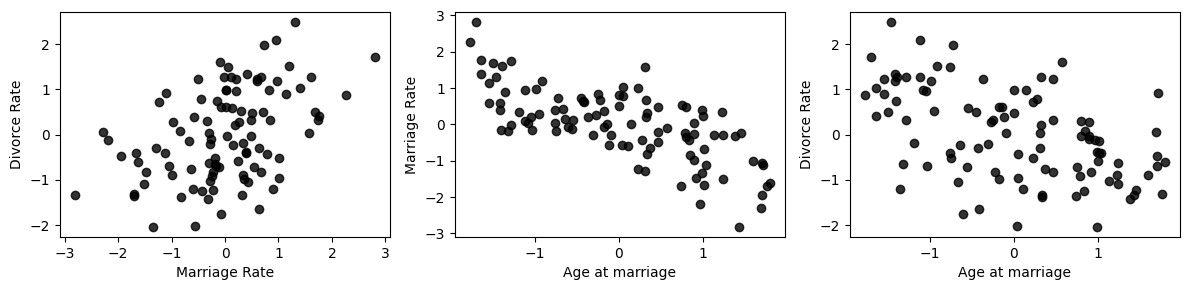

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))

ax1.scatter(sim_data['marriage_z'], sim_data['divorce_z'], c='black', alpha=0.8)
ax1.set_xlabel('Marriage Rate')
ax1.set_ylabel('Divorce Rate')

ax2.scatter(sim_data['age_z'], sim_data['marriage_z'], c='black', alpha=0.8)
ax2.set_xlabel('Age at marriage')
ax2.set_ylabel('Marriage Rate')

ax3.scatter(sim_data['age_z'], sim_data['divorce_z'], c='black', alpha=0.8)
ax3.set_xlabel('Age at marriage')
ax3.set_ylabel('Divorce Rate')

plt.tight_layout()
plt.show()

### Prior predictive distribution
Before we start running our statistical model, we do a prior predictive check. This is to make sure that our priors aren't totally crazy. Since we standardised our data, we actually set $\alpha$ to $0$. This means we can use a fairly tight prior for $\alpha$. For $\beta_A$ and $\beta_M$ however, the priors need to be looser and allow for more variation in slope. That said, for most biological data, slopes are never $>1$. Hence, we use gaussian priors for these variables with a standar deviation of $0.5$. 

In [13]:
a = rng.normal(0, 0.2, size=(100,))
b = xr.DataArray(rng.normal(0, 0.5, size=(100,2)), dims=['bA','bM'])

x = xr.DataArray(np.linspace(-2,2,50), dims='x')
y = a.reshape(100,1,1) + b*x

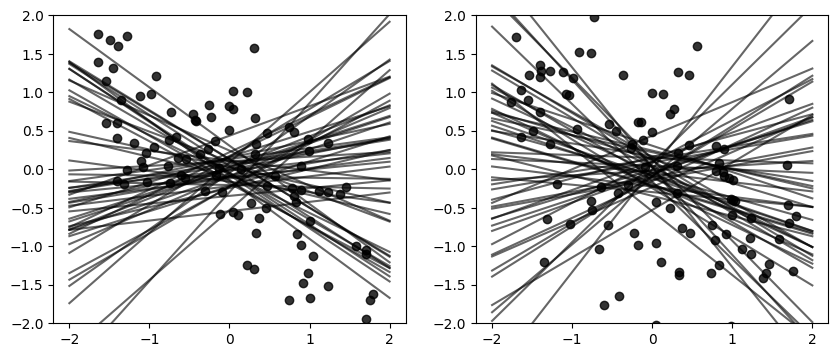

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(sim_data['age_z'], sim_data['marriage_z'], c='black', alpha=0.8)
ax2.scatter(sim_data['age_z'], sim_data['divorce_z'], c='black', alpha=0.8)
for i in range(50):
    ax1.plot(x, y[i][0], color='black', alpha=0.6)
    ax2.plot(x, y[i][1], color='black', alpha=0.6)

ax1.set_ylim(-2,2)
ax2.set_ylim(-2,2)

plt.show()

# 4. Design a statistical way to build the estimator using the generative model
### Fit model to generated data
Here, we fit a linear regression to the generated data.

In [15]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define likelihood
    divorce_z_obs = pm.Normal('divorce_z_obs', mu=alpha + beta_A * sim_data['age_z'] + beta_M * sim_data['marriage_z'], sigma=sigma, observed=sim_data['divorce_z'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.078,-0.151,0.147,0.001,0.001,3668.0,2919.0,1.0
beta_A,-0.382,0.118,-0.605,-0.162,0.002,0.002,2629.0,2642.0,1.0
beta_M,0.161,0.119,-0.073,0.367,0.002,0.002,2589.0,2332.0,1.0
sigma,0.869,0.062,0.752,0.981,0.001,0.001,3448.0,2865.0,1.0


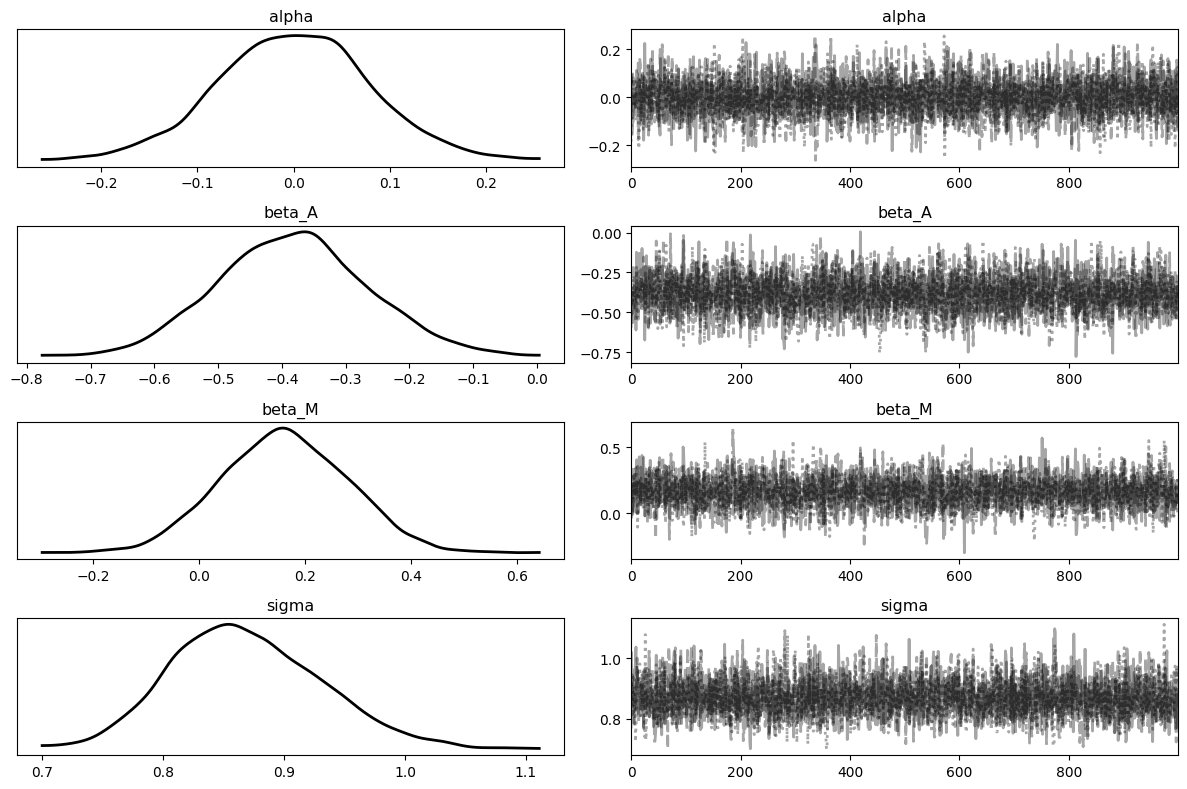

In [16]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': ['black', 'black'], 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

Most people will now report $\beta_M$ as the causal effect of marriage rate on divorce rate. This isn't completely wrong for this specific case because our model is completely linear. But this isn't what we're after. What we ideally want to do to get the causal effect of marriage on divorce is simulate an intervention. We want to simulate the distribution $D$ when we intervene on $M$ i.e., we want to remove all arrows that enter $M$ and isolate its effect on $D$. Our new DAG looks like this  

M &rarr; D  
&nbsp; &nbsp; ↗  
A

In [17]:
# Sample marriage age from the data
n_samples = 100
age_z_sampled = xr.DataArray(sim_data['age_z'].sample(n=n_samples, replace=True))
sigma_expanded = idata.posterior['sigma'].expand_dims(dim='samples', axis=-1)

# Simulate D for M=0
divorce_z_m0 = rng.normal(idata.posterior['alpha'] + idata.posterior['beta_M'] * 0 + idata.posterior['beta_A'] * age_z_sampled, sigma_expanded, size=(idata.posterior['alpha'].shape[0], idata.posterior['alpha'].shape[1], n_samples))

# Simulate D for M=1
divorce_z_m1 = rng.normal(idata.posterior['alpha'] + idata.posterior['beta_M'] * 1 + idata.posterior['beta_A'] * age_z_sampled, sigma_expanded, size=(idata.posterior['alpha'].shape[0], idata.posterior['alpha'].shape[1], n_samples))

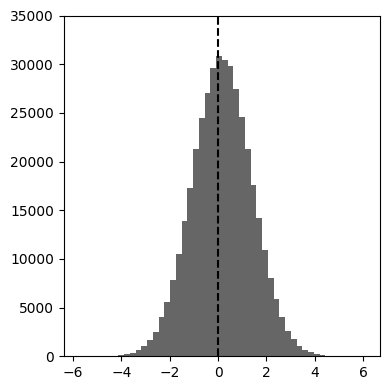

In [18]:
# Plot contrast between D(M=1) and D(M=0)
fig,ax = plt.subplots(1,1, figsize=(4, 4))

ax.hist(divorce_z_m1.reshape(-1) - divorce_z_m0.reshape(-1), color='black', alpha=0.6, bins=50)
ax.vlines(x=0, ymin=0, ymax=35000, color='black', linestyles='dashed')
ax.set_ylim(0,35000)
plt.tight_layout()
plt.show()

# 5. Analyse real data
Now that we know our model works with the synthetic data, we'll feed the real data from above.

In [19]:
df_sampled = df.sample(n=len(df))

df_sampled['marriage_z'] = (df_sampled['Marriage'] - df_sampled['Marriage'].mean()) / df_sampled['Marriage'].std()
df_sampled['divorce_z'] = (df_sampled['Divorce'] - df_sampled['Divorce'].mean()) / df_sampled['Divorce'].std()
df_sampled['age_z'] = (df_sampled['MedianAgeMarriage'] - df_sampled['MedianAgeMarriage'].mean()) / df_sampled['MedianAgeMarriage'].std()

In [20]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define likelihood
    divorce_z_obs = pm.Normal('divorce_z_obs', mu=alpha + beta_A * df_sampled['age_z'] + beta_M * df_sampled['marriage_z'], sigma=sigma, observed=df_sampled['divorce_z'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.101,-0.204,0.181,0.002,0.002,3347.0,2724.0,1.0
beta_A,-0.605,0.157,-0.904,-0.305,0.003,0.002,3315.0,2763.0,1.0
beta_M,-0.061,0.157,-0.355,0.231,0.003,0.002,3582.0,2803.0,1.0
sigma,0.826,0.088,0.671,0.993,0.002,0.001,3116.0,2295.0,1.0


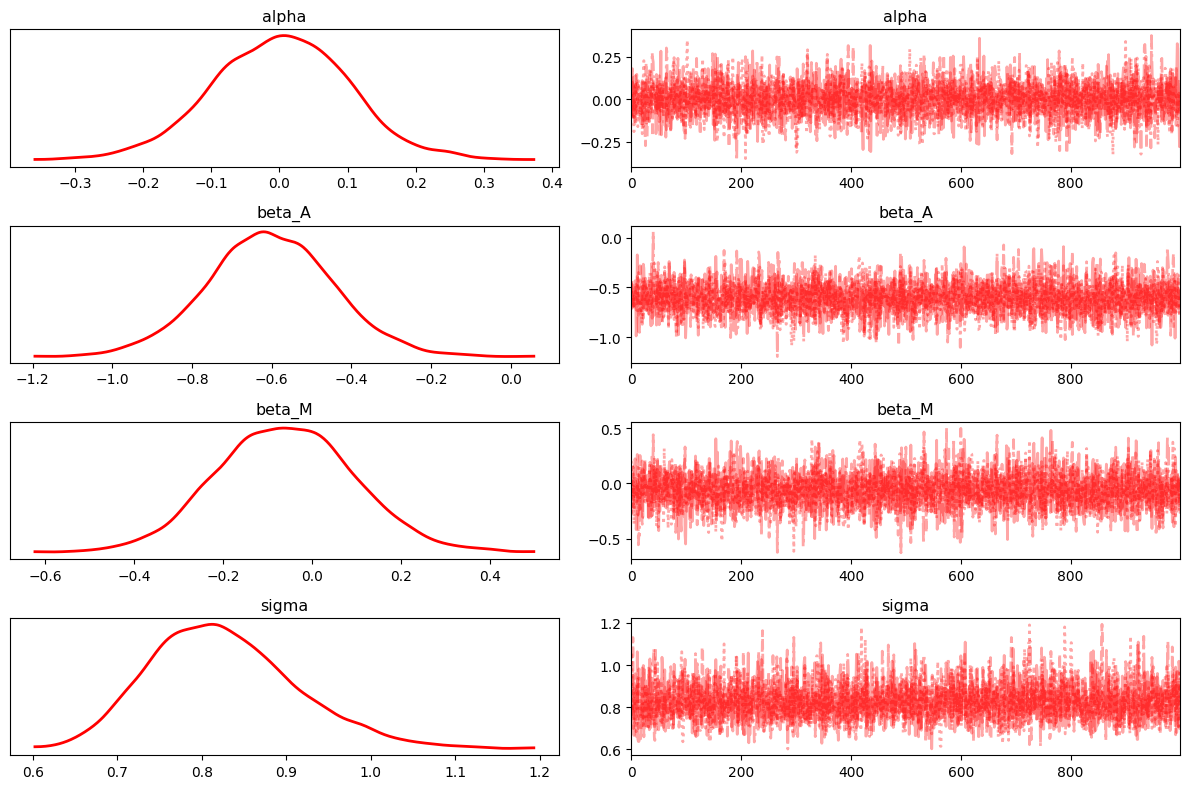

In [21]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': ['red', 'red'], 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

In [22]:
# Sample marriage age from the data
n_samples = 100
age_z_sampled = xr.DataArray(sim_data['age_z'].sample(n=n_samples, replace=True))
sigma_expanded = idata.posterior['sigma'].expand_dims(dim='samples', axis=-1)

# Simulate D for M=0
divorce_z_m0 = rng.normal(idata.posterior['alpha'] + idata.posterior['beta_M'] * 0 + idata.posterior['beta_A'] * age_z_sampled, sigma_expanded, size=(idata.posterior['alpha'].shape[0], idata.posterior['alpha'].shape[1], n_samples))

# Simulate D for M=1
divorce_z_m1 = rng.normal(idata.posterior['alpha'] + idata.posterior['beta_M'] * 1 + idata.posterior['beta_A'] * age_z_sampled, sigma_expanded, size=(idata.posterior['alpha'].shape[0], idata.posterior['alpha'].shape[1], n_samples))

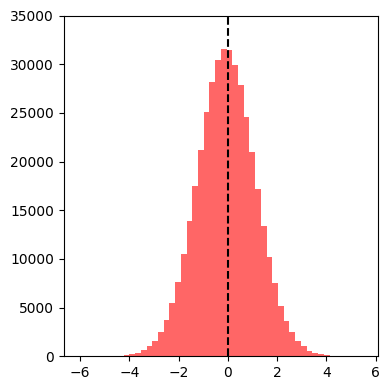

In [23]:
# Plot contrast between D(M=1) and D(M=0)
fig,ax = plt.subplots(1,1, figsize=(4, 4))

ax.hist(divorce_z_m1.reshape(-1) - divorce_z_m0.reshape(-1), color='red', alpha=0.6, bins=50)
ax.vlines(x=0, ymin=0, ymax=35000, color='black', linestyles='dashed')
ax.set_ylim(0,35000)
plt.tight_layout()
plt.show()

This is the posterior distribution of the causal effect of intervening on $M$ by increasing it by one standard deviation on divorce rate. This tells us that there is no causal effect of $M$ on $D$. Next, we will calculate the effect of $A$ on $D$. This will require similar code but we need to run another model. The reason we need this separate model is because there are no arrows entering $A$ that we need to delete. In this case, we want to ignore the effect of $M$. We will do this while addressing the second elemental confound, the pipe.

# The pipe
### X &rarr; Z &rarr; Y
#### For discrete variables

In [24]:
X = rng.binomial(1, 0.5, size=1000)
Z = rng.binomial(1, (1-X)*0.1 + X*0.9, size=1000)
Y = rng.binomial(1, (1-Z)*0.1 + Z*0.9, size=1000)

In [25]:
xy_corr = np.corrcoef(X,Y)

xy_corr_z0 = np.corrcoef(X[Z==0],Y[Z==0])
xy_corr_z1 = np.corrcoef(X[Z==1],Y[Z==1])

print(xy_corr[0,1], xy_corr_z0[0,1], xy_corr_z1[0,1])

0.6364125290215432 -0.03965270318653772 0.05337726359061226


#### For continuous variables

In [26]:
X = rng.normal(0, 1, size=500)
Z = rng.binomial(1, expit(X), size=500)
Y = rng.normal(2*(Z-1), size=500)

lm_xy = stats.linregress(X, Y)
lm_xy_z0 = stats.linregress(X[Z==0], Y[Z==0])
lm_xy_z1 = stats.linregress(X[Z==1], Y[Z==1])

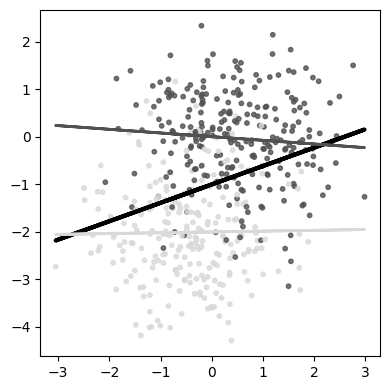

In [27]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(X, Y, c=Z, cmap='Greys', s=10, alpha=0.8, vmin=-0.5, vmax=1.5)
ax.plot(X, lm_xy[1] + lm_xy[0] * X, c='black', linewidth=3)
ax.plot(X, lm_xy_z0[1] + lm_xy_z0[0] * X, c=blacks[0], linewidth=2)
ax.plot(X, lm_xy_z1[1] + lm_xy_z1[0] * X, c=blacks[1], linewidth=2)

plt.tight_layout()
plt.show()

The way to then find the association between $X$ and $Y$ is by ignoring $Z$. We did this in our previous example where we ignored height when we wanted the total causal effect of $X$ on $Y$.

# The collider
### X &rarr; Z &larr; Y
#### For discrete variables

In [28]:
X = rng.binomial(1, 0.5, size=1000)
Y = rng.binomial(1, 0.5, size=1000)
Z = rng.binomial(1, np.where(X + Y > 0, 0.9, 0.2), size=1000)

In [29]:
xy_corr = np.corrcoef(X,Y)

xy_corr_z0 = np.corrcoef(X[Z==0],Y[Z==0])
xy_corr_z1 = np.corrcoef(X[Z==1],Y[Z==1])

print(xy_corr[0,1], xy_corr_z0[0,1], xy_corr_z1[0,1])

0.023719896946544958 0.4023888648108324 -0.317650993178396


#### For continuous variables

In [30]:
X = rng.normal(0, 1, size=500)
Y = rng.normal(0, 1, size=500)
Z = rng.binomial(1, expit(2*(X+Y-1)), size=500)

lm_xy = stats.linregress(X, Y)
lm_xy_z0 = stats.linregress(X[Z==0], Y[Z==0])
lm_xy_z1 = stats.linregress(X[Z==1], Y[Z==1])

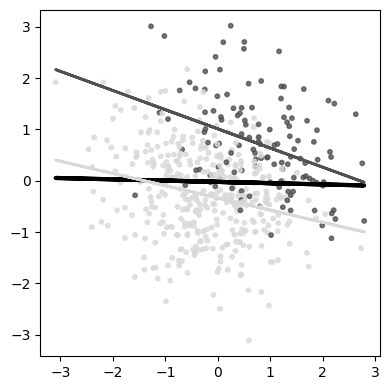

In [31]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(X, Y, c=Z, cmap='Greys', s=10, alpha=0.8, vmin=-0.5, vmax=1.5)
ax.plot(X, lm_xy[1] + lm_xy[0] * X, c='black', linewidth=3)
ax.plot(X, lm_xy_z0[1] + lm_xy_z0[0] * X, c=blacks[0], linewidth=2)
ax.plot(X, lm_xy_z1[1] + lm_xy_z1[0] * X, c=blacks[1], linewidth=2)

plt.tight_layout()
plt.show()

# The Descendant
### X &rarr; Z &rarr; Y
### &nbsp; &nbsp; &nbsp; &nbsp; &darr;
### &nbsp; &nbsp; &nbsp; &nbsp; A
Note that a descendant can be attached to anything. Here, it is attached to a pipe but it could be attached to a fork or a collider too and in all cases, its effects depend on what it is attached to. Stratifying or conditioning on a descendent is like conditioning on its parent. In the above example, including $A$ in the model is like including $Z$, but more weakly.
#### For discrete variables

In [32]:
X = rng.binomial(1, 0.5, size=1000)
Z = rng.binomial(1, (1-X)*0.1 + X*0.9, size=1000)
Y = rng.binomial(1, (1-Z)*0.1 + Z*0.9, size=1000)
A = rng.binomial(1, (1-Z)*0.1 + Z*0.9, size=1000)

In [33]:
xy_corr = np.corrcoef(X,Y)

xy_corr_a0 = np.corrcoef(X[A==0],Y[A==0])
xy_corr_a1 = np.corrcoef(X[A==1],Y[A==1])

print(xy_corr[0,1], xy_corr_a0[0,1], xy_corr_a1[0,1])

0.6980684140570315 0.4163554503515595 0.393379027139108
